In [1]:
import pandas as pd
import numpy as np
import joblib
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [2]:
import pandas as pd


In [3]:
import numpy as np


In [4]:
import matplotlib.pyplot as plt


In [5]:
import seaborn as sns


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer



In [7]:
def load_data_from_csv(csv_file_path):
    print(f"Loading data from {csv_file_path}...")

    df = pd.read_csv(
    csv_file_path,
    skiprows=2,
    header=0,
    names=["Tweet Number", "Clause Number", "Clause", "Final Sentiment"]
)

    df = df.dropna(subset=['Clause', 'Final Sentiment'])
    df['Clause'] = df['Clause'].astype(str).str.strip()
    df['Final Sentiment'] = df['Final Sentiment'].astype(str).str.strip().str.lower() # Show first 5 rows for debugging

    print("Rows before cleaning:", len(df))
    missing_clause = df['Clause'].isna().sum()
    missing_sentiment = df['Final Sentiment'].isna().sum()
    print(f"Rows with missing Clause: {missing_clause}")
    print(f"Rows with missing Final Sentiment: {missing_sentiment}")

    df = df.dropna(subset=['Clause', 'Final Sentiment'])
    print("Rows after cleaning:", len(df))

    df['Clause'] = df['Clause'].astype(str).str.strip()
    df['Final Sentiment'] = df['Final Sentiment'].astype(str).str.strip().str.lower()

    print(f"📊 Loaded {len(df)} clauses from {df['Tweet Number'].nunique()} tweets")
    print("Sentiment distribution:", df['Final Sentiment'].value_counts().to_dict())

    tweet_data = []
    for tweet_num, tweet_group in df.groupby('Tweet Number'):
        clauses = []
        tweet_group = tweet_group.sort_values('Clause Number')
        for _, row in tweet_group.iterrows():
            clauses.append({
                'clause_text': row['Clause'],
                'sentiment': row['Final Sentiment']
            })
        tweet_data.append({
            'tweet_id': tweet_num,
            'clauses': clauses
        })

    print(f"Data conversion completed: {len(tweet_data)} tweets ready for training")
    return tweet_data

In [8]:
class TaglishSentimentAnalyzer:
    def __init__(self, vectorizer=None, model=None,
                 max_features=30000, 
                 ngram_range=(1, 2),
                 alpha=0.1,
                 pos_threshold=0.2,
                 neg_threshold=-0.2):
        
        self.max_features = max_features
        self.ngram_range = ngram_range
        self.alpha = alpha
        self.pos_threshold = pos_threshold
        self.neg_threshold = neg_threshold
        self.vectorizer = vectorizer
        self.model = model

        self.class_weights = None
        self.classes = None
        self.is_fitted = False

        self.training_history = {}

    def predict(self, text):
        X = self.vectorizer.transform([text])
        prediction = self.model.predict(X)[0]
        probs = self.model.predict_proba(X)[0]
        return {
            "text": text,
            "prediction": prediction,
            "probabilities": dict(zip(self.model.classes_, probs))
        }
        
    def _setup_vectorizer(self):
        """Setup TF-IDF vectorizer for Taglish text"""
        self.vectorizer = TfidfVectorizer(
            max_features=self.max_features,
            ngram_range=self.ngram_range,
            lowercase=True,
            strip_accents='unicode',
            stop_words=None,
            min_df=1,
            max_df=0.95,
            sublinear_tf=True,
            norm='l2'
        )
        
    def _setup_model(self):
        """Setup Multinomial Naive Bayes model"""
        self.model = MultinomialNB(
            alpha=self.alpha,
            fit_prior=True
        )
        
    def _compute_class_weights(self, y):
        self.classes = np.unique(y)
        class_weights = compute_class_weight('balanced', classes=self.classes, y=y)
        self.class_weights = dict(zip(self.classes, class_weights))
        return self.class_weights
    
    def prepare_data(self, tweet_data):
        clause_data = []
        
        for tweet in tweet_data:
            tweet_id = tweet['tweet_id']
            for clause_idx, clause in enumerate(tweet['clauses']):
                clause_data.append({
                    'tweet_id': tweet_id,
                    'clause_idx': clause_idx,
                    'clause_text': clause['clause_text'],
                    'sentiment': clause['sentiment']
                })
        
        return pd.DataFrame(clause_data)
    
    # New method: train the model
    def train(self, tweet_data):
        """Fit vectorizer and train the model"""
        df = self.prepare_data(tweet_data)
        X = self.vectorizer.fit_transform(df['clause_text'])
        y = df['sentiment'].values
        self.classes = np.unique(y)
        self.model.fit(X, y)
        self.is_fitted = True
        print(f"Model trained on {len(y)} clauses with classes: {self.classes}")
    
    def predict_text(self, text):
        if not self.is_fitted:
            raise ValueError("Model is not trained yet. Please train or load a model first.")
    
        # Transform input into TF-IDF features
        X = self.vectorizer.transform([text])
    
        # Predict class
        prediction = self.model.predict(X)[0]
    
        # Predict probabilities
        probs = self.model.predict_proba(X)[0]
        prob_dict = dict(zip(self.model.classes_, probs))
    
        return {
            "text": text,
            "prediction": prediction,
            "probabilities": prob_dict
        }


In [9]:
def train(self, tweet_data, cv_folds=10, cv_repeats=3, verbose=True):
    """Train the sentiment analysis model with cross-validation"""
    if verbose:
        print("Starting Taglish Sentiment Model Training...")
        
    #Prepare clause-level data
    clause_df = self.prepare_data(tweet_data)
    
    if verbose:
        print(f"Prepared {len(clause_df)} clauses from {len(tweet_data)} tweets")
        print("Class distribution:", Counter(clause_df['sentiment']))
    
    #Setup components
    self._setup_vectorizer()
    self._setup_model()
    
    #Extract features and labels
    X_text = clause_df['clause_text'].tolist()
    y = clause_df['sentiment'].values
    
    #Fit vectorizer and transform data
    if verbose:
        print("🔧 Fitting TF-IDF vectorizer...")
    X = self.vectorizer.fit_transform(X_text)
    
    #Compute class weights
    self.class_weights = self._compute_class_weights(y)
    if verbose:
        print("Class weights:", self.class_weights)
    
    #Cross-validation
    cv = RepeatedStratifiedKFold(n_splits=cv_folds, n_repeats=cv_repeats, random_state=42)
    
    fold_results = []
    all_predictions = []
    all_true_labels = []
    
    if verbose:
        print(f"Starting {cv_folds}-fold CV with {cv_repeats} repeats...")
    
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        if verbose and fold_idx % 5 == 0:
            print(f"   Processing fold {fold_idx + 1}/{cv_folds * cv_repeats}")
        
        #Split data
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        #Create model for this fold
        fold_model = MultinomialNB(alpha=self.alpha, fit_prior=True)
        
        #Apply class weights through sample weights
        sample_weights = np.array([self.class_weights[label] for label in y_train])
        fold_model.fit(X_train, y_train, sample_weight=sample_weights)
        
        #Predict
        y_pred = fold_model.predict(X_test)
        
        #Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average='weighted', zero_division=0
        )
        
        fold_results.append({
            'fold': fold_idx + 1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
        
        all_predictions.extend(y_pred)
        all_true_labels.extend(y_test)
    
    #Calculate final metrics
    results_df = pd.DataFrame(fold_results)
    
    self.training_history = {
        'cv_results': results_df,
        'mean_accuracy': results_df['accuracy'].mean(),
        'std_accuracy': results_df['accuracy'].std(),
        'mean_precision': results_df['precision'].mean(),
        'std_precision': results_df['precision'].std(),
        'mean_recall': results_df['recall'].mean(),
         'std_recall': results_df['recall'].std(),
        'mean_f1': results_df['f1'].mean(),
        'std_f1': results_df['f1'].std(),
        'classification_report': classification_report(all_true_labels, all_predictions, zero_division=0),
        'class_distribution': Counter(y),
        'n_features': X.shape[1],
        'n_samples': X.shape[0]
    }
    
    if verbose:
        print("\nCross-Validation Results:")
        print(f"   Accuracy:  {self.training_history['mean_accuracy']:.4f} ± {self.training_history['std_accuracy']:.4f}")
        print(f"   Precision: {self.training_history['mean_precision']:.4f} ± {self.training_history['std_precision']:.4f}")
        print(f"   Recall:    {self.training_history['mean_recall']:.4f} ± {self.training_history['std_recall']:.4f}")
        print(f"   F1-Score:  {self.training_history['mean_f1']:.4f} ± {self.training_history['std_f1']:.4f}")
    
    #Train final model on all data
    if verbose:
        print("Training final model on complete dataset...")
    
    sample_weights = np.array([self.class_weights[label] for label in y])
    self.model.fit(X, y, sample_weight=sample_weights)
    self.is_fitted = True
    
    if verbose:
        print("Model training completed!")
    
    return self.training_history

# Attach to class
TaglishSentimentAnalyzer.train = train

In [10]:
def predict_clause_sentiment(self, clause_text):
    """Predict sentiment for a single clause"""
    if not self.is_fitted:
        raise ValueError("Model must be trained before making predictions")
    
    if isinstance(clause_text, str):
        clause_text = [clause_text]
    
    # Vectorize
    X = self.vectorizer.transform(clause_text)
    
    # Predict
    prediction = self.model.predict(X)[0]
    probabilities = self.model.predict_proba(X)[0]
    confidence = np.max(probabilities)
    
    return prediction, confidence

def predict_tweet_sentiment(self, tweet_clauses):
    """Predict sentiment for a complete tweet using clause aggregation"""
    if not self.is_fitted:
        raise ValueError("Model must be trained before making predictions")
    
    # Vectorize clauses
    clause_vectors = self.vectorizer.transform(tweet_clauses)

    # Get clause-level predictions and probabilities
    clause_predictions = self.model.predict(clause_vectors)
    clause_probabilities = self.model.predict_proba(clause_vectors)
    
    # Calculate TF-IDF weights for each clause
    clause_tfidf_weights = np.array(clause_vectors.sum(axis=1)).flatten()
    
    if clause_tfidf_weights.sum() > 0:
        clause_tfidf_weights = clause_tfidf_weights / clause_tfidf_weights.sum()
    else:
        clause_tfidf_weights = np.ones(len(tweet_clauses)) / len(tweet_clauses)
    
    # Weighted average of probabilities
    weighted_probs = np.average(clause_probabilities, weights=clause_tfidf_weights, axis=0)
    
    # Convert to sentiment score
    class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
    
    if 'positive' in class_to_idx and 'negative' in class_to_idx:
        pos_idx = class_to_idx['positive']
        neg_idx = class_to_idx['negative']
        sentiment_score = weighted_probs[pos_idx] - weighted_probs[neg_idx]
    else:
        sentiment_score = 0.0
    
    # Apply threshold rules
    if sentiment_score >= self.pos_threshold:
        tweet_sentiment = 'positive'
    elif sentiment_score <= self.neg_threshold:
        tweet_sentiment = 'negative'
    else:
        tweet_sentiment = 'neutral'
    
    return tweet_sentiment, sentiment_score, clause_predictions.tolist()

# Add prediction methods to the class
TaglishSentimentAnalyzer.predict_clause_sentiment = predict_clause_sentiment
TaglishSentimentAnalyzer.predict_tweet_sentiment = predict_tweet_sentiment

print("Prediction methods added to class!")

Prediction methods added to class!


In [11]:
def save_model(self, filepath='taglish_sentiment_model.pkl'):
    """Save the complete trained model to a pickle file"""
    if not self.is_fitted:
        raise ValueError("Model must be trained before saving")
    
    model_data = {
        'vectorizer': self.vectorizer,
        'model': self.model,
        'class_weights': self.class_weights,
        'classes': self.classes,
        'parameters': {
            'max_features': self.max_features,
            'ngram_range': self.ngram_range,
            'alpha': self.alpha,
            'pos_threshold': self.pos_threshold,
            'neg_threshold': self.neg_threshold
        },
        'training_history': self.training_history,
        'is_fitted': self.is_fitted
    }
    
    with open(filepath, 'wb') as f:
        pickle.dump(model_data, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    file_size = self._get_file_size(filepath)
    print(f"Model saved successfully to {filepath}")
    print(f"Model size: {file_size:.2f} MB")

@staticmethod
def load_model(filepath='taglish_sentiment_model.pkl'):
    """Load a trained model from a pickle file"""
    with open(filepath, 'rb') as f:
        model_data = pickle.load(f)
    
    # Create new instance
    analyzer = TaglishSentimentAnalyzer(
        max_features=model_data['parameters']['max_features'],
        ngram_range=model_data['parameters']['ngram_range'],
        alpha=model_data['parameters']['alpha'],
        pos_threshold=model_data['parameters']['pos_threshold'],
        neg_threshold=model_data['parameters']['neg_threshold']
    )
    
    # Restore trained components
    analyzer.vectorizer = model_data['vectorizer']
    analyzer.model = model_data['model']
    analyzer.class_weights = model_data['class_weights']
    analyzer.classes = model_data['classes']
    analyzer.training_history = model_data['training_history']
    analyzer.is_fitted = model_data['is_fitted']
    
    print(f"Model loaded successfully from {filepath}")
    if analyzer.training_history:
        print(f"   Training accuracy:  {analyzer.training_history['mean_accuracy']:.4f}")
        print(f"   Training precision: {analyzer.training_history['mean_precision']:.4f}")
        print(f"   Training recall:    {analyzer.training_history['mean_recall']:.4f}")
        print(f"   Training F1-score:  {analyzer.training_history['mean_f1']:.4f}")
    
    return analyzer

def _get_file_size(self, filepath):
    """Get file size in MB"""
    import os
    return os.path.getsize(filepath) / (1024 * 1024)

def get_model_info(self):
    """Get information about the trained model"""
    if not self.is_fitted:
        return "Model not trained yet"
    
    info = {
        'is_trained': self.is_fitted,
        'n_features': self.training_history.get('n_features', 'Unknown'),
        'n_samples': self.training_history.get('n_samples', 'Unknown'),
        'classes': self.classes.tolist() if self.classes is not None else [],
        'class_weights': self.class_weights,
        'mean_cv_accuracy': self.training_history.get('mean_accuracy', 'Unknown'),
        'mean_cv_f1': self.training_history.get('mean_f1', 'Unknown'),
        'parameters': {
            'max_features': self.max_features,
            'ngram_range': self.ngram_range,
            'alpha': self.alpha,
            'pos_threshold': self.pos_threshold,
            'neg_threshold': self.neg_threshold
        }
    }
    
    return info

TaglishSentimentAnalyzer.save_model = save_model
TaglishSentimentAnalyzer.load_model = load_model
TaglishSentimentAnalyzer._get_file_size = _get_file_size
TaglishSentimentAnalyzer.get_model_info = get_model_info

In [12]:
def plot_class_distribution(tweet_data):
    """Plot the distribution of sentiment classes"""
    # Extract all clause sentiments
    all_sentiments = []
    for tweet in tweet_data:
        for clause in tweet['clauses']:
            all_sentiments.append(clause['sentiment'])
    
    # Count sentiments
    sentiment_counts = Counter(all_sentiments)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
    
    plt.subplot(1, 2, 1)
    bars = plt.bar(sentiment_counts.keys(), sentiment_counts.values(), color=colors)
    plt.title('Clause-level Sentiment Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')
    
    # Pie chart
    plt.subplot(1, 2, 2)
    plt.pie(sentiment_counts.values(), labels=sentiment_counts.keys(), 
            autopct='%1.1f%%', colors=colors, startangle=90)
    plt.title('Sentiment Distribution (%)')
    
    plt.tight_layout()
    plt.show()
    
    return sentiment_counts

def plot_training_results(training_history):
    """Plot cross-validation results"""
    if not training_history or 'cv_results' not in training_history:
        print("No training history available")
        return
    
    cv_results = training_history['cv_results']
    
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.hist(cv_results['accuracy'], bins=15, alpha=0.7, color='#45b7d1', edgecolor='black')
    plt.axvline(cv_results['accuracy'].mean(), color='red', linestyle='--', 
                label=f'Mean: {cv_results["accuracy"].mean():.4f}')
    plt.title('Cross-Validation Accuracy Distribution')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    plt.legend()
    
    # F1-score plot
    plt.subplot(1, 2, 2)
    plt.hist(cv_results['f1'], bins=15, alpha=0.7, color='#4ecdc4', edgecolor='black')
    plt.axvline(cv_results['f1'].mean(), color='red', linestyle='--', 
                label=f'Mean: {cv_results["f1"].mean():.4f}')
    plt.title('Cross-Validation F1-Score Distribution')
    plt.xlabel('F1-Score')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [13]:
def train_model_from_csv(csv_file_path, model_save_path='taglish_sentiment_model.pkl', show_plots=True):
    """Load CSV, train Taglish sentiment model, optionally plot data & training results, save model"""
    
    # Load data from CSV
    tweet_data = load_data_from_csv(csv_file_path)
    
    # Data visualization
    if show_plots:
        print("\nData Visualization:")
        sentiment_counts = plot_class_distribution(tweet_data)
        print("Sentiment counts:", sentiment_counts)
    
    # Initialize model
    print("\nInitializing model...")
    analyzer = TaglishSentimentAnalyzer(
        max_features=10000,
        ngram_range=(1, 2),
        alpha=1.0,
        pos_threshold=0.2,
        neg_threshold=-0.2
    )
    
    # Train the model
    training_results = analyzer.train(tweet_data, cv_folds=10, cv_repeats=10, verbose=True)
    
    # Show training results
    if show_plots:
        print("\nTraining Results Visualization:")
        plot_training_results(training_results)
    
    # Save the model
    analyzer.save_model(model_save_path)
    
    # Print summary
    print("\nTraining Summary:")
    print("="*50)
    print(f"Accuracy: {training_results['mean_accuracy']:.4f} ± {training_results['std_accuracy']:.4f}")
    print(f"F1-Score: {training_results['mean_f1']:.4f} ± {training_results['std_f1']:.4f}")
    print(f"Features: {training_results['n_features']}")
    print(f"Samples: {training_results['n_samples']}")
    print(f"Model saved to: {model_save_path}")
    
    return analyzer


In [14]:
def load_data_from_csv_with_split(csv_file_path, test_size=0.1, random_state=42):
    """Load data from CSV and split into training and testing sets at the tweet level"""
    
    print(f"Loading data from {csv_file_path}...")
    df = pd.read_csv(
        csv_file_path,
        skiprows=2, #skipping 2 rows 
        header=0,
        names=["Tweet Number", "Clause Number", "Clause", "Final Sentiment"]
    )
    
    print("Columns found:", df.columns.tolist())
    print("First 5 rows:")
    print(df.head(5))

    print(f"Rows before cleaning: {len(df)}")
    missing_clause = df['Clause'].isna().sum()
    missing_sentiment = df['Final Sentiment'].isna().sum()
    print(f"Rows with missing Clause: {missing_clause}")
    print(f"Rows with missing Final Sentiment: {missing_sentiment}")

    # Clean data
    df = df.dropna(subset=['Clause', 'Final Sentiment'])
    print(f"Rows after cleaning: {len(df)}")

    df['Clause'] = df['Clause'].astype(str).str.strip()
    df['Final Sentiment'] = df['Final Sentiment'].astype(str).str.strip().str.lower()

    print(f"Loaded {len(df)} clauses from {df['Tweet Number'].nunique()} tweets")
    print("Sentiment distribution:", df['Final Sentiment'].value_counts().to_dict())

    # Convert to tweet structure
    tweet_data = []
    for tweet_num, tweet_group in df.groupby('Tweet Number'):
        clauses = []
        tweet_group = tweet_group.sort_values('Clause Number')
        
        # Collect all sentiments in this tweet for stratification
        tweet_sentiments = tweet_group['Final Sentiment'].tolist()
        
        for _, row in tweet_group.iterrows():
            clauses.append({
                'clause_text': row['Clause'],
                'sentiment': row['Final Sentiment']
            })
            
        tweet_data.append({
            'tweet_id': tweet_num,
            'clauses': clauses,
            'tweet_sentiments': tweet_sentiments
        })

    print(f"Data conversion completed: {len(tweet_data)} tweets ready")
    
    #TRAIN/TEST SPLIT
    print(f"\nSplitting data: {int((1-test_size)*100)}% train, {int(test_size*100)}% test")
    
    stratify_labels = []
    for tweet in tweet_data:
        sentiment_counts = Counter(tweet['tweet_sentiments'])
        dominant_sentiment = sentiment_counts.most_common(1)[0][0]
        stratify_labels.append(dominant_sentiment)
    
    print("Tweet-level sentiment distribution for stratification:")
    label_dist = Counter(stratify_labels)
    print(label_dist)
    
    #Split tweets (not clauses) into train/test
    train_tweets, test_tweets, train_labels, test_labels = train_test_split(
        tweet_data,
        stratify_labels,
        test_size=test_size,
        random_state=random_state,
        stratify=stratify_labels  # Maintain sentiment distribution
    )
    
    #Remove the temporary stratification field
    for tweet in train_tweets + test_tweets:
        tweet.pop('tweet_sentiments', None)
    
    #Calculate statistics
    train_clauses = sum(len(tweet['clauses']) for tweet in train_tweets)
    test_clauses = sum(len(tweet['clauses']) for tweet in test_tweets)
    
    #Get clause-level sentiment distributions
    train_clause_sentiments = []
    test_clause_sentiments = []
    
    for tweet in train_tweets:
        for clause in tweet['clauses']:
            train_clause_sentiments.append(clause['sentiment'])
    
    for tweet in test_tweets:
        for clause in tweet['clauses']:
            test_clause_sentiments.append(clause['sentiment'])
    
    train_sent_dist = Counter(train_clause_sentiments)
    test_sent_dist = Counter(test_clause_sentiments)
    
    #Create summary info
    data_info = {
        'total_tweets': len(tweet_data),
        'total_clauses': len(df),
        'train_tweets': len(train_tweets),
        'test_tweets': len(test_tweets),
        'train_clauses': train_clauses,
        'test_clauses': test_clauses,
        'train_sentiment_dist': train_sent_dist,
        'test_sentiment_dist': test_sent_dist,
        'test_size_actual': len(test_tweets) / len(tweet_data)
    }
    
    #Print split summary
    print(f"\nSPLIT SUMMARY:")
    print(f"{'='*50}")
    print(f"TRAINING SET:")
    print(f"Tweets: {data_info['train_tweets']:,} ({data_info['train_tweets']/data_info['total_tweets']*100:.1f}%)")
    print(f"Clauses: {data_info['train_clauses']:,} ({data_info['train_clauses']/(data_info['train_clauses']+data_info['test_clauses'])*100:.1f}%)")
    print(f"Sentiment distribution: {dict(train_sent_dist)}")
    
    print(f"\nTESTING SET:")
    print(f"Tweets: {data_info['test_tweets']:,} ({data_info['test_tweets']/data_info['total_tweets']*100:.1f}%)")
    print(f"Clauses: {data_info['test_clauses']:,} ({data_info['test_clauses']/(data_info['train_clauses']+data_info['test_clauses'])*100:.1f}%)")
    print(f"Sentiment distribution: {dict(test_sent_dist)}")
    
    print(f"\nSplit completed successfully!")
    
    return train_tweets, test_tweets, data_info

def train_model_with_holdout_test(csv_file_path, 
                                  test_size=0.1, 
                                  model_save_path='taglish_sentiment_model.pkl',
                                  show_plots=True):
    """Complete pipeline with proper train/test split"""
    
    print("TRAINING WITH HOLDOUT TEST SET")
    print("="*60)
    
    #Load and split data
    train_data, test_data, data_info = load_data_from_csv_with_split(
        csv_file_path, test_size=test_size
    )
    
    #Data visualization for training set
    if show_plots:
        print("\nTraining Data Visualization:")
        plot_class_distribution(train_data)
    
    #Train model ONLY on training data
    analyzer = TaglishSentimentAnalyzer(
        max_features=10000,
        ngram_range=(1, 2),
        alpha=1.0,
        pos_threshold=0.2,
        neg_threshold=-0.2
    )
    
    #Train with cross-validation on training data only
    training_results = analyzer.train(train_data, cv_folds=10, cv_repeats=3, verbose=True)
    
    #Test on held-out test set
    print(f"\nTESTING ON HELD-OUT TEST SET ({len(test_data)} tweets)")
    print("="*50)
    
    test_results = evaluate_on_test_set(analyzer, test_data)
    
    #Save model
    analyzer.save_model(model_save_path)
    
    #Print final comparison
    print(f"\nFINAL RESULTS COMPARISON:")
    print("="*50)
    print(f"Cross-Validation (Training): {training_results['mean_accuracy']:.4f} ± {training_results['std_accuracy']:.4f}")
    print(f"Held-out Test Set:{test_results['accuracy']:.4f}")
    print(f"Generalization Gap:{training_results['mean_accuracy'] - test_results['accuracy']:+.4f}")
    
    if abs(training_results['mean_accuracy'] - test_results['accuracy']) < 0.05:
        print("Model performs similarly on unseen data.")
    else:
        print("Consider regularization or more data.")
    
    return analyzer, test_results, data_info

def evaluate_on_test_set(analyzer, test_data):
    """Evaluate trained model on held-out test set"""
    
    if not analyzer.is_fitted:
        raise ValueError("Model must be trained before testing!")
    
    # Prepare test data (same as training data preparation)
    test_clause_df = analyzer.prepare_data(test_data)
    
    X_test_text = test_clause_df['clause_text'].tolist()
    y_test = test_clause_df['sentiment'].values
    
    # Transform using the SAME vectorizer fitted on training data
    X_test = analyzer.vectorizer.transform(X_test_text)
    
    # Predict on test set
    y_pred = analyzer.model.predict(X_test)
    y_pred_proba = analyzer.model.predict_proba(X_test)
    
    # Calculate metrics
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
    
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)
    
    test_results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'n_test_clauses': len(y_test),
        'n_test_tweets': len(test_data),
        'classification_report': classification_report(y_test, y_pred),
        'predictions': y_pred.tolist(),
        'true_labels': y_test.tolist()
    }
    
    print(f"TEST SET PERFORMANCE:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   Test clauses: {len(y_test):,}")
    print(f"   Test tweets: {len(test_data):,}")
    
    print(f"\nDetailed Test Set Classification Report:")
    print(test_results['classification_report'])
    
    return test_results

if __name__ == "__main__":
    print("How to use:")
    print("Load and split data:")
    print("   train_data, test_data, info = load_data_from_csv_with_split('your_file.csv')")
    print()
    print("Train with proper evaluation:")
    print("   analyzer, test_results, info = train_model_with_holdout_test('your_file.csv')")
    print()


How to use:
Load and split data:
   train_data, test_data, info = load_data_from_csv_with_split('your_file.csv')

Train with proper evaluation:
   analyzer, test_results, info = train_model_with_holdout_test('your_file.csv')



In [15]:
train_data, test_data, split_info = load_data_from_csv_with_split("Final_Annotation.csv", test_size=0.1)

Loading data from Final_Annotation.csv...
Columns found: ['Tweet Number', 'Clause Number', 'Clause', 'Final Sentiment']
First 5 rows:
   Tweet Number  Clause Number  \
0             2              1   
1             3              1   
2             4              1   
3             5              1   
4             5              2   

                                              Clause Final Sentiment  
0  kung sino man yang 12k na bumoto kay quiboloy ...        Negative  
1                       na dinaya ang botohan kaloka        Negative  
2  so far bam kiko luke amp heidi frontrunner sa ...        Positive  
3  inanunsyo ng commission on elections comelec a...         Neutral  
4  at minority party sa bilangpilipino2025 ang la...         Neutral  
Rows before cleaning: 37312
Rows with missing Clause: 0
Rows with missing Final Sentiment: 0
Rows after cleaning: 37312
Loaded 37312 clauses from 19953 tweets
Sentiment distribution: {'neutral': 21225, 'negative': 12073, 'positive': 40

TRAINING WITH HOLDOUT TEST SET
Loading data from Final_Annotation.csv...
Columns found: ['Tweet Number', 'Clause Number', 'Clause', 'Final Sentiment']
First 5 rows:
   Tweet Number  Clause Number  \
0             2              1   
1             3              1   
2             4              1   
3             5              1   
4             5              2   

                                              Clause Final Sentiment  
0  kung sino man yang 12k na bumoto kay quiboloy ...        Negative  
1                       na dinaya ang botohan kaloka        Negative  
2  so far bam kiko luke amp heidi frontrunner sa ...        Positive  
3  inanunsyo ng commission on elections comelec a...         Neutral  
4  at minority party sa bilangpilipino2025 ang la...         Neutral  
Rows before cleaning: 37312
Rows with missing Clause: 0
Rows with missing Final Sentiment: 0
Rows after cleaning: 37312
Loaded 37312 clauses from 19953 tweets
Sentiment distribution: {'neutral': 21225, 'n

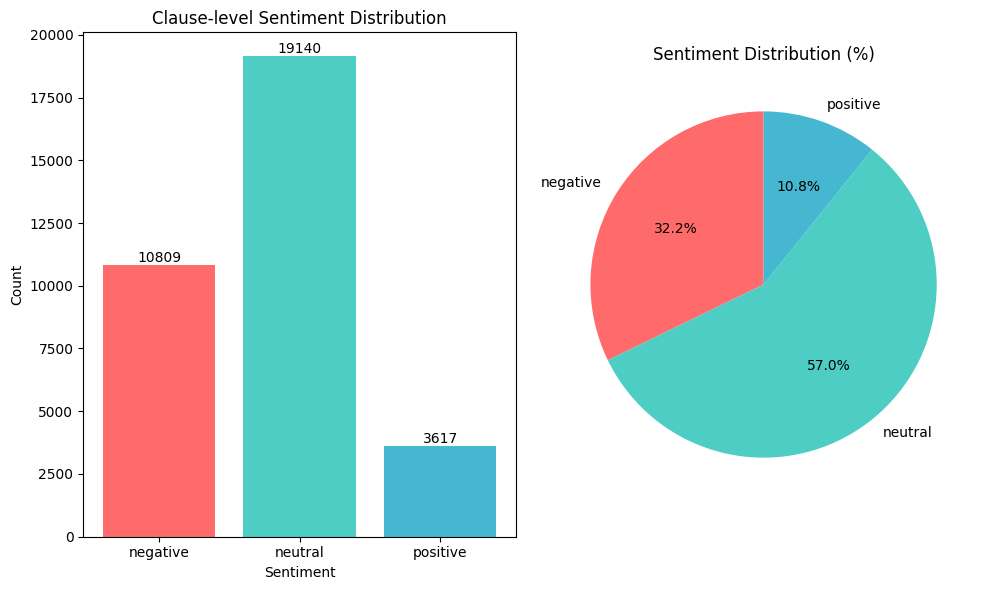

Starting Taglish Sentiment Model Training...
Prepared 33566 clauses from 17957 tweets
Class distribution: Counter({'neutral': 19140, 'negative': 10809, 'positive': 3617})
🔧 Fitting TF-IDF vectorizer...
Class weights: {'negative': 1.0351250501125606, 'neutral': 0.5845698362939742, 'positive': 3.093355451110497}
Starting 10-fold CV with 3 repeats...
   Processing fold 1/30
   Processing fold 6/30
   Processing fold 11/30
   Processing fold 16/30
   Processing fold 21/30
   Processing fold 26/30

Cross-Validation Results:
   Accuracy:  0.6397 ± 0.0084
   Precision: 0.7284 ± 0.0070
   Recall:    0.6397 ± 0.0084
   F1-Score:  0.6488 ± 0.0082
Training final model on complete dataset...
Model training completed!

TESTING ON HELD-OUT TEST SET (1996 tweets)
TEST SET PERFORMANCE:
   Accuracy:  0.6508
   Precision: 0.7361
   Recall:    0.6508
   F1-Score:  0.6589
   Test clauses: 3,746
   Test tweets: 1,996

Detailed Test Set Classification Report:
              precision    recall  f1-score   su

In [16]:
analyzer, test_results, info = train_model_with_holdout_test('Final_Annotation.csv')

In [17]:
#test using unseen data, lagay ka lang ng random na tweet
result1 = analyzer.predict_text("Grabe super panget ng pamumuno ng government ngayon at pano ba sila nabubuhay na alam nilang maraming namamatay na mamamamayan sa drug war nila?")
print(result1)

result2 = analyzer.predict_text("")
print(result2)


#Expected output
#'text': '', (yung text na nilagay mo)
#   'prediction': np.str_('positive/negative/neutral'), 
#   'probabilities': {np.str_('negative'): np.float64(0.3333333333333231), np.str_('neutral'): np.float64(0.33333333333329523), np.str_('positive'): np.float64(0.3333333333333817)}}
#   Yung mga probabilities nakalista rito, kung ano yung confidence nila per class of sentiment, nakalagay sa float. 

{'text': 'Grabe super panget ng pamumuno ng government ngayon at pano ba sila nabubuhay na alam nilang maraming namamatay na mamamamayan sa drug war nila?', 'prediction': 'negative', 'probabilities': {'negative': 0.6698491340272791, 'neutral': 0.1688931548707842, 'positive': 0.16125771110193354}}
{'text': '', 'prediction': 'positive', 'probabilities': {'negative': 0.3333333333333231, 'neutral': 0.33333333333329523, 'positive': 0.3333333333333817}}


In [18]:
#Summarizarion lang nung accuracy, precision, recall, f1 score ng model
loaded_analyzer = TaglishSentimentAnalyzer.load_model('taglish_sentiment_model.pkl')

Model loaded successfully from taglish_sentiment_model.pkl
   Training accuracy:  0.6397
   Training precision: 0.7284
   Training recall:    0.6397
   Training F1-score:  0.6488


In [19]:

tweet_data = load_data_from_csv("Final_Annotation.csv")
analyzer = TaglishSentimentAnalyzer()

history = analyzer.train(tweet_data)

results_df = history['cv_results']
print(results_df)

Loading data from Final_Annotation.csv...
Rows before cleaning: 37312
Rows with missing Clause: 0
Rows with missing Final Sentiment: 0
Rows after cleaning: 37312
📊 Loaded 37312 clauses from 19953 tweets
Sentiment distribution: {'neutral': 21225, 'negative': 12073, 'positive': 4014}
Data conversion completed: 19953 tweets ready for training
Starting Taglish Sentiment Model Training...
Prepared 37312 clauses from 19953 tweets
Class distribution: Counter({'neutral': 21225, 'negative': 12073, 'positive': 4014})
🔧 Fitting TF-IDF vectorizer...
Class weights: {'negative': 1.0301775311300698, 'neutral': 0.585975657636435, 'positive': 3.0984886231523}
Starting 10-fold CV with 3 repeats...
   Processing fold 1/30
   Processing fold 6/30
   Processing fold 11/30
   Processing fold 16/30
   Processing fold 21/30
   Processing fold 26/30

Cross-Validation Results:
   Accuracy:  0.6668 ± 0.0076
   Precision: 0.7268 ± 0.0068
   Recall:    0.6668 ± 0.0076
   F1-Score:  0.6742 ± 0.0074
Training final m

In [20]:
results_df['accuracy_diff_from_mean'] = results_df['accuracy'] - results_df['accuracy'].mean()
results_df['f1_diff_from_mean'] = results_df['f1'] - results_df['f1'].mean()

print(results_df[['fold','accuracy','accuracy_diff_from_mean','f1','f1_diff_from_mean']])


    fold  accuracy  accuracy_diff_from_mean        f1  f1_diff_from_mean
0      1  0.666667                -0.000161  0.673190          -0.001042
1      2  0.673633                 0.006806  0.681342           0.007110
2      3  0.669258                 0.002430  0.676214           0.001981
3      4  0.669258                 0.002430  0.676518           0.002285
4      5  0.674350                 0.007523  0.681228           0.006996
5      6  0.667917                 0.001090  0.674674           0.000441
6      7  0.654784                -0.012043  0.662721          -0.011511
7      8  0.658001                -0.008827  0.666162          -0.008071
8      9  0.665237                -0.001590  0.673889          -0.000344
9     10  0.666577                -0.000250  0.674761           0.000528
10    11  0.667203                 0.000375  0.675706           0.001474
11    12  0.672562                 0.005734  0.680131           0.005898
12    13  0.673010                 0.006183  0.6791

In [21]:
from scipy.stats import friedmanchisquare
import numpy as np

# Friedman test across folds (accuracy)
accuracies = results_df['accuracy'].values

stat, p = friedmanchisquare(accuracies)
print("Friedman test p-value:", p)


ValueError: At least 3 sets of samples must be given for Friedman test, got 1.